# COBRE dataset BrainGAT & MLP Implementation with Performance Comparison

This code is retrieved from CogniNet repository and changes made for performance visualization and for optimization purposes

In [1]:
!pip install torch

In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
Looking in links: https://data.pyg.org/whl/torch-{torch.__version__}.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-r8eb2d15
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-r8eb2d15
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 61c47ee404f8e26b3a1cd0db56448b6254920d0e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install torch torchvision

In [4]:
!pip install torch_geometric

# Imports

In [69]:
import os
import scipy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import io
from typing import Union, Any, Optional, List, Dict, Tuple
from tqdm import tqdm

from dataclasses import dataclass, field
from pathlib import Path

import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.nn import Parameter, Linear

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

import torch_geometric
import torch_geometric as pyg
from torch_geometric.typing import Size, OptTensor
from torch_geometric.nn import global_add_pool, global_mean_pool, MessagePassing, GATConv, GCNConv, PNAConv
from torch_geometric.nn import Sequential as pygSequential
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.utils import softmax
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
import seaborn as sns


In [7]:
print('torch', torch.__version__)
print('torch_geometric', torch_geometric.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch 2.2.1+cu121
torch_geometric 2.6.0
cuda


In [8]:
cobre_csvs_path =  '../cobre/aal/'

# Fom connectivity matrices to pytorch geometric (PyG) data

In [9]:
def cm_to_edges(cm: np.ndarray):
    """
    Convert CM to (edge_index, edge_weights) of a fully connected weighted graph
    (including self-loops with zero weights)
    return: (edge_index, edge_weights)
    """
    cm = torch.FloatTensor(cm)
    index = (torch.isnan(cm) == 0).nonzero(as_tuple=True)
    edge_attr = torch.abs(cm[index])

    return torch.stack(index, dim=0), edge_attr

def prepare_pyg_data(
    cm: np.ndarray,
    subj_id: str,
    targets: int,
) -> Data:

    # fully connected graph
    n = cm.shape[0]
    edge_index, edge_attr = cm_to_edges(cm)

    # compute initial node embeddings -> just original weights
    x = torch.from_numpy(cm).to(device)

    # get encoded labels
    y = F.one_hot(torch.tensor([targets-1]), num_classes=2).to(device) # we took targets-1 because targets in abide are 1 and 2

    data = Data(
        edge_index=edge_index,
        edge_attr=edge_attr,
        x=x,
        num_nodes=n,
        y=y,
        subj_id=subj_id,
    )

    return data

## COBRE

COBRE dataset is pretty small so the deep ML models overfit too easily

In [10]:
cobre_y = pd.read_csv('cobre/cobre_targets.tsv', delimiter='\t')
cobre_y.head()

,Study,Projectid,Description,Subjectid,Age,Sex,Dx,Field_strength,Img_date,Datauri,Maker,Model,Szc_protocol_hier,Notes,Imaging_protocol_site,Visit
0,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,970414,Siemens,MIND TRIO 3.0T,Resting_State,NaN,MRN,NaN
1,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980034,Siemens,MIND TRIO 3.0T,MPRAGE,NaN,MRN,NaN
2,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980054,Siemens,MIND TRIO 3.0T,MPRAGE,NaN,MRN,NaN
3,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980134,Siemens,MIND TRIO 3.0T,Diffusion,NaN,MRN,NaN
4,COBRE,1139,The Center for Biomedical Research Excellence ...,A00000300,36,male,No_Known_Disorder,3,2011-01-01 00:00:00.0,980154,Siemens,MIND TRIO 3.0T,Diffusion,NaN,MRN,NaN


In [13]:
cobre_splits = json.load(open('cobre/cobre_splits_new.json')) # here we also use the same train test splits as for classic ML
train_ids = [i['train']+i['valid'] for i in cobre_splits['train']]
train_ids = train_ids[0]+train_ids[1]+train_ids[2]+train_ids[3]+train_ids[4]
train_ids = list(set(train_ids))
test_ids = cobre_splits['test']
group = np.array(cobre_y.Dx)

In [14]:
X = []
Y = []
subj_ids = []
missed_ids = []
for subj, y in zip(train_ids+test_ids, group):
    try:
        X.append(np.array(pd.read_csv('cobre/aal/sub-'+subj+'.csv').drop('Unnamed: 0', axis=1)))
        Y.append(y)
        subj_ids.append(str(subj))
    except:
        missed_ids.append(str(subj))

X = np.array(X)
Y = np.array(Y)

dict_X = dict(zip(subj_ids, X))
dict_Y = dict(zip(cobre_y[cobre_y.Subjectid.isin(subj_ids)].Subjectid, cobre_y[cobre_y.Subjectid.isin(subj_ids)].Dx))
xx, yy = dict_Y.keys(), dict_Y.values()
yy = [1 if i == 'Schizophrenia_Strict' else 2 for i in yy]
dict_Y = dict(zip(xx, yy))

In [15]:
# creation of PyG dataloaders and common dataloaders
# PyG data has specific batching

train_inps, train_tgts = [], []
train_loader_pyg = []
for x, subj_id, y in zip(X, train_ids, Y):
    train_loader_pyg.append(prepare_pyg_data(dict_X[subj_id], subj_id, dict_Y[subj_id]))
    train_inps.append(dict_X[subj_id])
    train_tgts.append(F.one_hot(torch.tensor([dict_Y[subj_id]-1]), num_classes=2).to(device))

test_inps, test_tgts = [], []
test_loader_pyg = []
for x, subj_id, y in zip(X, test_ids, Y):
    test_loader_pyg.append(prepare_pyg_data(dict_X[subj_id], subj_id, dict_Y[subj_id]))
    test_inps.append(dict_X[subj_id])
    test_tgts.append(F.one_hot(torch.tensor([dict_Y[subj_id]-1]), num_classes=2).to(device))

dataset = torch.utils.data.TensorDataset(torch.Tensor(train_inps).to(device), torch.cat(train_tgts, axis=0).to(device))
train_loader_cobre = torch.utils.data.DataLoader(dataset, batch_size=16)
dataset = torch.utils.data.TensorDataset(torch.Tensor(test_inps).to(device), torch.cat(test_tgts, axis=0).to(device))
test_loader_cobre = torch.utils.data.DataLoader(dataset, batch_size=16)

train_loader_cobre_pyg = DataLoader(train_loader_pyg, batch_size=8)
test_loader_cobre_pyg = DataLoader(test_loader_pyg, batch_size=8)

<ipython-input-15-569deceedffe>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  dataset = torch.utils.data.TensorDataset(torch.Tensor(train_inps).to(device), torch.cat(train_tgts, axis=0).to(device))


In [16]:
next(iter(train_loader_cobre))[0].shape, next(iter(train_loader_cobre))[1].shape

(torch.Size([16, 116, 116]), torch.Size([16, 2]))

In [17]:
next(iter(train_loader_cobre_pyg)) # x

DataBatch(x=[928, 116], edge_index=[2, 107648], edge_attr=[107648], y=[8, 2], num_nodes=928, subj_id=[8], batch=[928], ptr=[9])

# Train and evaluate functions

In [54]:
def evaluate(model, device, loader):
    model.eval()  # Set model to evaluation mode

    loss_all = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)

            # Calculate binary cross-entropy from logits
            loss = F.binary_cross_entropy_with_logits(out, data.y.float().to(device))
            loss_all += loss.item()

            # Convert logits to probabilities using sigmoid
            probabilities = out.detach().cpu().numpy()
            y_pred.extend(probabilities)
            y_true.extend(data.y.detach().cpu().numpy())

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    f1, acc, roc_auc = f1_score(y_true.argmax(-1), y_pred.argmax(-1)), accuracy_score(y_true.argmax(-1), y_pred.argmax(-1)), roc_auc_score(y_true.argmax(-1), y_pred[:, 1])

    return loss_all/len(loader.dataset), f1, acc, roc_auc, y_pred, y_true

In [55]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, scheduler=None, device='cuda', n_epochs=20, verbose=True):
    model.train()  # Set model to train mode

    # Initialize lists to store metrics and final predictions
    metrics = {
        'train_f1s': [],
        'train_accs': [],
        'train_roc_aucs': [],
        'train_losses': [],
        'test_f1s': [],
        'test_accs': [],
        'test_roc_aucs': [],
        'test_losses': [],
        'final_test_y_pred': None,
        'final_test_y_true': None
    }

    for i in range(n_epochs):
        loss_all = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.cross_entropy(out, data.y.to(device).float())
            loss.backward()
            optimizer.step()
            loss_all += loss.item()

        if scheduler:
            scheduler.step()

        epoch_loss = loss_all / len(train_loader.dataset)
        metrics['train_losses'].append(epoch_loss)

        train_loss, train_f1, train_acc, train_roc_auc, _, _ = evaluate(model, device, train_loader)
        metrics['train_f1s'].append(train_f1)
        metrics['train_accs'].append(train_acc)
        metrics['train_roc_aucs'].append(train_roc_auc)

        test_loss, test_f1, test_acc, test_roc_auc, test_y_pred, test_y_true = evaluate(model, device, test_loader)
        metrics['test_losses'].append(test_loss)
        metrics['test_f1s'].append(test_f1)
        metrics['test_accs'].append(test_acc)
        metrics['test_roc_aucs'].append(test_roc_auc)

        if i == n_epochs - 1:  # Save predictions from the last epoch
            metrics['final_test_y_pred'] = test_y_pred
            metrics['final_test_y_true'] = test_y_true

        if verbose:
            print(f'(Epoch {i}) | Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc * 100:.2f}%')

    return metrics

# Neurograph
main idea of architechture was taken from https://github.com/gennadylaptev/neurograph/tree/main/neurograph with additions

In [56]:
@dataclass
class MLPlayer:
    """ Config of one MLP layer """
    out_size: int = 10
    act_func: Optional[str] = 'ReLU'
    act_func_params: Optional[dict] = None
    dropout: Optional[float] = None

In [57]:
@dataclass
class MLPConfig:
    """ Config of MLP model """
    # layers define only hidden dimensions, so final MLP will have n+1 layer.
    # So, if you want to create a 1-layer network, just leave layers empty

    # in and out sizes are optional and usually depend on upstream model and the task
    # for now, they are ignored
    in_size: Optional[int] = None
    out_size: Optional[int] = None

    # act func for the last layer. None -> no activation function
    act_func: Optional[str] = None
    act_func_params: Optional[dict] = None
    layers: List[MLPlayer] = field(default_factory=lambda: [
        MLPlayer(
            out_size=32, dropout=0.6, act_func='LeakyReLU', act_func_params=dict(negative_slope=0.2)
        ),
        MLPlayer(
            out_size=32, dropout=0.6, act_func='LeakyReLU', act_func_params=dict(negative_slope=0.2)
        ),
    ])

In [58]:
def build_mlp_layer(in_size: int, layer: MLPlayer) -> nn.Sequential:
    """ Factory that returns nn.Sequential from input size and MLPlayer """
    act_params = layer.act_func_params if layer.act_func_params else {}

    lst: list[nn.Module] = [nn.Linear(in_size, layer.out_size)]
    #lst.append(
    if layer.act_func:
        lst.append(nn.LeakyReLU(**act_params)) # available_activations[layer.act_func](**act_params))
    if layer.dropout:
        lst.append(nn.Dropout(layer.dropout, inplace=True))
    return nn.Sequential(*lst)

In [59]:
@dataclass
class ModelConfig:
    """ Base class for model config """
    name: str  # see neurograph.models/
    n_classes: int  # must match with loss

    data_type: str

In [60]:
class BasicMLP(nn.Module):
    """ Basic MLP class """
    def __init__(self, in_size: int, out_size: int, config: MLPConfig):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size

        self.net = nn.Sequential()
        curr_size = self.in_size
        for layer_conf in config.layers:
            subnet = build_mlp_layer(curr_size, layer_conf)
            self.net.append(subnet)
            curr_size = layer_conf.out_size

        # the last layer
        self.net.append(build_mlp_layer(
            curr_size,
            MLPlayer(
                out_size=self.out_size,
                act_func=config.act_func,
                act_func_params=config.act_func_params,
            ),
        ))

    def forward(self, x):
        return self.net(x)

In [61]:
def build_gat_block(
    input_dim: int,
    hidden_dim: int,
    proj_dim: Optional[int] = None,
    num_heads: int = 1,
    dropout: float = 0.0,
    use_batchnorm: bool = True,
    use_abs_weight: bool = True,
):
    proj_dim = hidden_dim if proj_dim is None else proj_dim
    return pygSequential(
        'x, edge_index, edge_attr',
        [
            (
                GATConv(
                    input_dim,
                    hidden_dim,
                    heads=num_heads,
                    dropout=dropout,
                    concat=True,
                ),
                'x, edge_index, edge_attr -> x'
            ),
            nn.Linear(hidden_dim * num_heads, proj_dim),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.Dropout(p=dropout)
        ]
    )

In [62]:
def concat_pool(x: torch.Tensor, input_dim: int, num_nodes: int) -> torch.Tensor:
    # NB: x must be a batch of xs
    return x.reshape((x.shape[0] // input_dim, input_dim*x.shape[-1]))

In [63]:
class BrainGAT(nn.Module):
    def __init__(
        self,
        # determined by dataset
        input_dim: int,
        num_nodes: int,
        num_classes: int
    ):
        """
        Architecture:
            - a list of GATConv blocks (n-1)
            - the last layer GATConv block with diff final embedding size
            - (prepool projection layer)
            - pooling -> graph embeddgin
            - fcn clf
        """
        super().__init__()

        self.convs = torch.nn.ModuleList()
        self.input_dim = input_dim
        self.num_nodes = num_nodes

        num_classes = num_classes
        hidden_dim = 32

        num_layers = 3

        use_batchnorm = True
        use_abs_weight = True
        # mp_type = 'node_concate'
        dropout = 0

        num_heads = 2

        # pack a bunch of convs into a ModuleList
        gat_input_dim = input_dim
        for _ in range(num_layers - 1):
            conv = build_gat_block(
                gat_input_dim,
                hidden_dim,
                proj_dim=None,
                # mp_type=mp_type,
                num_heads=num_heads,
                dropout=dropout,
                use_batchnorm=use_batchnorm,
                use_abs_weight=use_abs_weight,
            )
            # update current input_dim
            gat_input_dim = hidden_dim
            self.convs.append(conv)

        # gat block return embeddings of `inter_dim` size
        conv = build_gat_block(
            gat_input_dim,
            hidden_dim,
            proj_dim=64,
            # mp_type=mp_type,
            num_heads=num_heads,
            dropout=dropout,
            use_batchnorm=False,  # batchnorm is applied in prepool layer
            use_abs_weight=use_abs_weight,
        )
        # add extra projection and batchnorm
        self.prepool = nn.Sequential(
            nn.Linear(64, 8),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(8) if use_batchnorm else nn.Identity(),
        )

        fcn_dim = 8 * num_nodes

        # add last conv layer
        self.convs.append(conv)

        self.fcn = BasicMLP(in_size=fcn_dim, out_size=num_classes, config=MLPConfig())

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        z = x
        z = z.float()

        # apply conv layers
        for _, conv in enumerate(self.convs):
            z = conv(z, edge_index, edge_attr)

        # prepool dim reduction
        z = self.prepool(z)

        z = nn.BatchNorm1d(num_features=z.shape[-1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)(z)

        # pooling
        z = concat_pool(z, self.input_dim, self.num_nodes)
        # FCN clf on graph embedding
        z = nn.BatchNorm1d(num_features=z.shape[-1], eps=1e-05, momentum=0.1, affine=True, track_running_stats=True).to(device)(z)
        out = self.fcn(z)
        out=nn.Softmax(dim=-1)(out)
        return out

## COBRE

In [64]:
bgbGAT = BrainGAT(116, 116, 2)
bgbGAT = bgbGAT.to(device)
bgbGAT = bgbGAT.float()
optimizer = torch.optim.AdamW(bgbGAT.parameters(), lr=0.001)

In [65]:
metrics = train_and_evaluate(
    bgbGAT,
    train_loader_cobre_pyg,
    test_loader_cobre_pyg,
    optimizer,
    scheduler=None,
    device=device,
    n_epochs=60
)

(Epoch 0) | Train Loss: 0.0871, Test Loss: 0.1145, Test Acc: 50.00%
(Epoch 1) | Train Loss: 0.0830, Test Loss: 0.1144, Test Acc: 50.00%
(Epoch 2) | Train Loss: 0.0811, Test Loss: 0.1140, Test Acc: 53.85%
(Epoch 3) | Train Loss: 0.0782, Test Loss: 0.1143, Test Acc: 57.69%
(Epoch 4) | Train Loss: 0.0708, Test Loss: 0.1177, Test Acc: 57.69%
(Epoch 5) | Train Loss: 0.0630, Test Loss: 0.1211, Test Acc: 46.15%
(Epoch 6) | Train Loss: 0.0608, Test Loss: 0.1189, Test Acc: 50.00%
(Epoch 7) | Train Loss: 0.0605, Test Loss: 0.1172, Test Acc: 57.69%
(Epoch 8) | Train Loss: 0.0557, Test Loss: 0.1175, Test Acc: 57.69%
(Epoch 9) | Train Loss: 0.0552, Test Loss: 0.1179, Test Acc: 57.69%
(Epoch 10) | Train Loss: 0.0597, Test Loss: 0.1107, Test Acc: 73.08%
(Epoch 11) | Train Loss: 0.0526, Test Loss: 0.1125, Test Acc: 61.54%
(Epoch 12) | Train Loss: 0.0527, Test Loss: 0.0987, Test Acc: 69.23%
(Epoch 13) | Train Loss: 0.0548, Test Loss: 0.1204, Test Acc: 53.85%
(Epoch 14) | Train Loss: 0.0551, Test Loss: 

ValueError: multilabel-indicator format is not supported

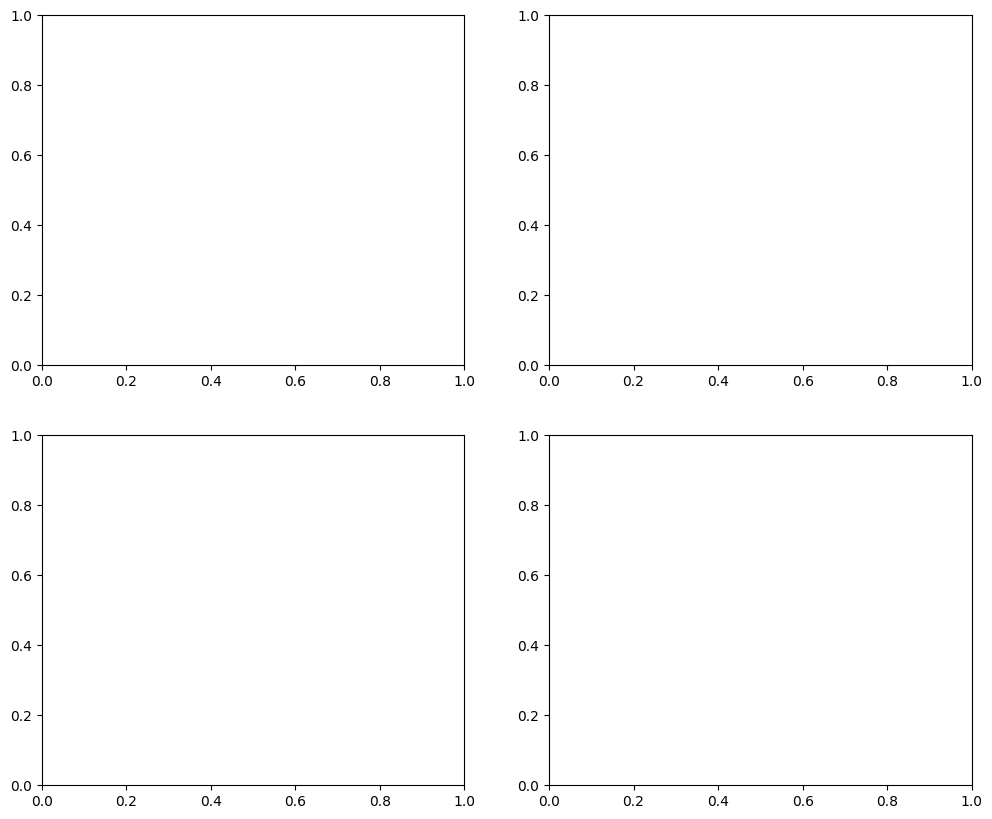

In [66]:
def train_and_collect_data():
    res_bgbgat_cobre = []
    for _ in range(10):
        bgbGAT = BrainGAT(116, 116, 2)
        bgbGAT = bgbGAT.to(device)
        bgbGAT = bgbGAT.float()
        optimizer = torch.optim.AdamW(bgbGAT.parameters(), lr=0.001)
        res = train_and_evaluate(
            bgbGAT,
            train_loader_cobre_pyg,
            test_loader_cobre_pyg,
            optimizer,
            scheduler=None,
            device=device,
            n_epochs=60,
            verbose=False
        )
        res_bgbgat_cobre.append(res)
    return res_bgbgat_cobre

res_bgbgat_cobre = train_and_collect_data()

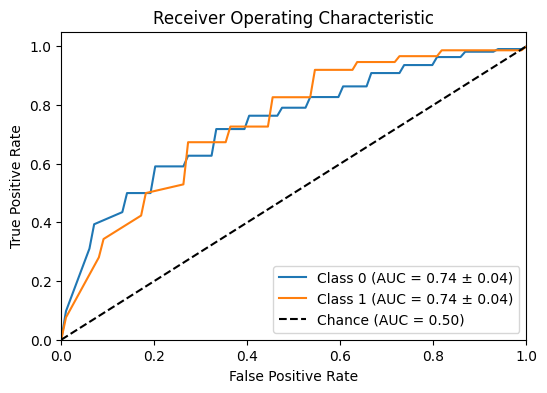

In [77]:
def plot_performance(res_bgbgat_cobre):
    n_classes = 2  # Specify the number of classes if not binary
    fig, ax = plt.subplots(figsize=(6, 4))  # Single plot

    # Prepare ROC curve data
    mean_fpr = np.linspace(0, 1, 100)
    tprs = [[] for _ in range(n_classes)]
    aucs = [[] for _ in range(n_classes)]

    # Accumulate ROC data from all runs
    for res in res_bgbgat_cobre:
        y_true = label_binarize(res['final_test_y_true'], classes=[i for i in range(n_classes)])
        if y_true.shape[1] == 1:  # Handle binary case
            y_true = np.hstack([1 - y_true, y_true])

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true[:, i], res['final_test_y_pred'][:, i])
            roc_auc = auc(fpr, tpr)
            tprs[i].append(np.interp(mean_fpr, fpr, tpr))
            tprs[i][-1][0] = 0.0
            aucs[i].append(roc_auc)

    # Plot ROC curves for each class
    for i in range(n_classes):
        mean_tpr = np.mean(tprs[i], axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs[i])
        ax.plot(mean_fpr, mean_tpr, label=f'Class {i} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

    # Add chance line, labels, legend, and title
    ax.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

    plt.show()

# Example usage
plot_performance(res_bgbgat_cobre)

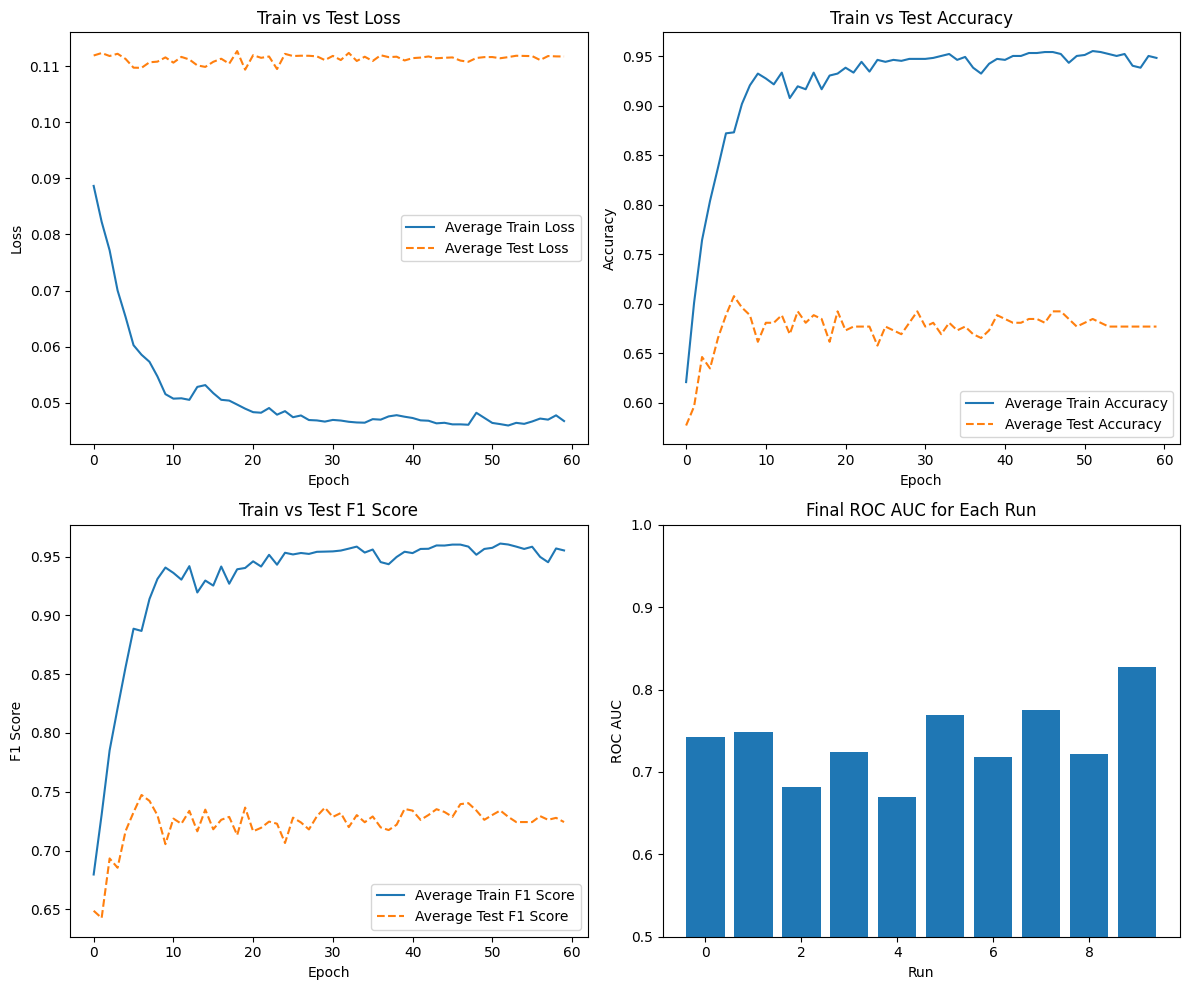

In [73]:
def plot_performance_metrics(res_bgbgat_cobre):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Aggregate the metrics from each run
    all_train_losses = np.array([run['train_losses'] for run in res_bgbgat_cobre])
    all_test_losses = np.array([run['test_losses'] for run in res_bgbgat_cobre])
    all_train_f1s = np.array([run['train_f1s'] for run in res_bgbgat_cobre])
    all_test_f1s = np.array([run['test_f1s'] for run in res_bgbgat_cobre])
    all_train_accs = np.array([run['train_accs'] for run in res_bgbgat_cobre])
    all_test_accs = np.array([run['test_accs'] for run in res_bgbgat_cobre])

    epochs = range(len(all_train_losses[0]))

    # Plot Training and Testing Losses
    axes[0, 0].plot(epochs, np.mean(all_train_losses, axis=0), label='Average Train Loss')
    axes[0, 0].plot(epochs, np.mean(all_test_losses, axis=0), label='Average Test Loss', linestyle='--')
    axes[0, 0].set_title('Train vs Test Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot Training and Testing Accuracy
    axes[0, 1].plot(epochs, np.mean(all_train_accs, axis=0), label='Average Train Accuracy')
    axes[0, 1].plot(epochs, np.mean(all_test_accs, axis=0), label='Average Test Accuracy', linestyle='--')
    axes[0, 1].set_title('Train vs Test Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot Training and Testing F1-Scores
    axes[1, 0].plot(epochs, np.mean(all_train_f1s, axis=0), label='Average Train F1 Score')
    axes[1, 0].plot(epochs, np.mean(all_test_f1s, axis=0), label='Average Test F1 Score', linestyle='--')
    axes[1, 0].set_title('Train vs Test F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()

    # Average ROC AUC for the final epoch across all runs
    final_roc_aucs = [run['test_roc_aucs'][-1] for run in res_bgbgat_cobre]
    axes[1, 1].bar(range(len(final_roc_aucs)), final_roc_aucs)
    axes[1, 1].set_title('Final ROC AUC for Each Run')
    axes[1, 1].set_xlabel('Run')
    axes[1, 1].set_ylabel('ROC AUC')
    axes[1, 1].set_ylim([0.5, 1])  # Assuming ROC AUC should be between 0.5 and 1

    plt.tight_layout()
    plt.show()

# Example usage with your data
plot_performance_metrics(res_bgbgat_cobre)

# Performance analysis of bgbGAT

In [78]:
def summarize_metrics(res_bgbgat_cobre):
    # Initialize an empty list to collect all run data
    data = []

    # Iterate over each run's results
    for run in res_bgbgat_cobre:
        # Each run's final test metrics are taken for summary
        data.append({
            'Test Accuracy': run['test_accs'][-1],  # last epoch accuracy
            'Test F1 Score': run['test_f1s'][-1],   # last epoch F1 score
            'Test ROC-AUC': run['test_roc_aucs'][-1]  # last epoch ROC-AUC
        })

    # Create DataFrame
    df = pd.DataFrame(data)

    # Calculate statistics
    summary_stats = df.agg(['mean', 'std', 'max']).transpose()

    return summary_stats

summary_stats = summarize_metrics(res_bgbgat_cobre)
summary_stats

                   mean       std       max
Test Accuracy  0.676923  0.057906  0.769231
Test F1 Score  0.724315  0.054029  0.812500
Test ROC-AUC   0.737879  0.046206  0.827273
